In [28]:
!pip install gradio==3.50.2 ipywidgets==8.1.1

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!/usr/local/nvidia/bin/nvidia-smi

Thu Dec 21 09:11:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   65C    P0    30W /  70W |   6311MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In this project we will build a nice web app that allows you to swap out the background of a subject and substitute it with an image generated by Stable Diffusion through a text prompt:

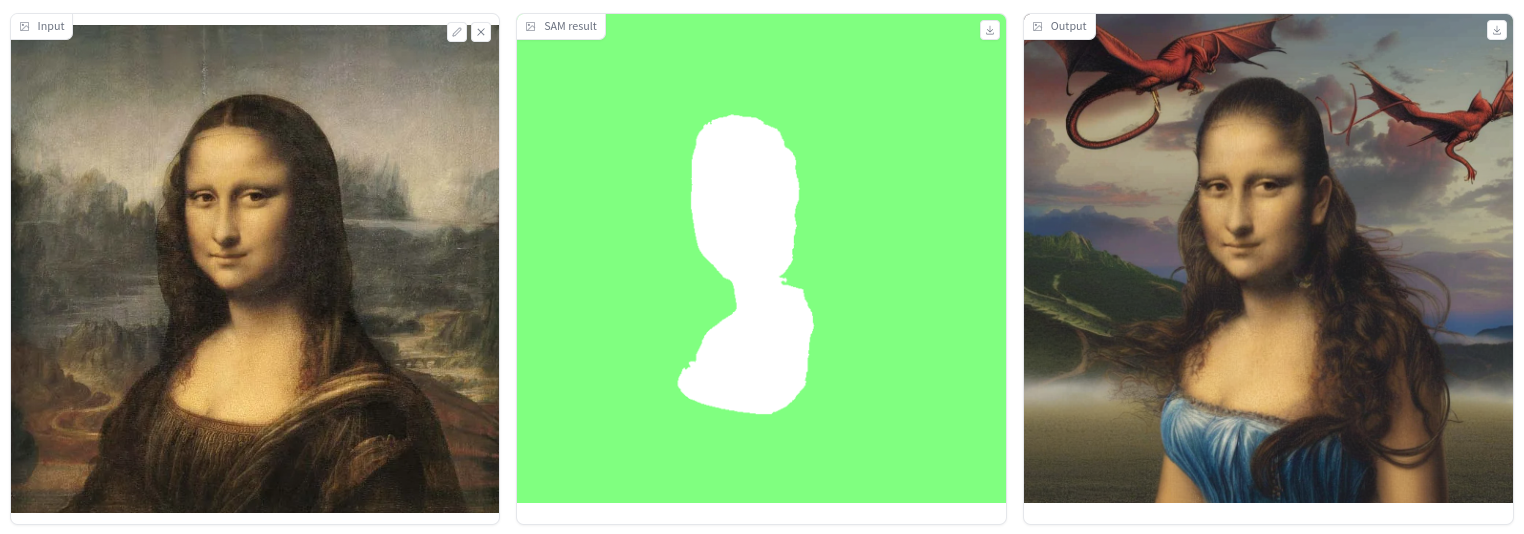

Let's start by importing what we need:

In [3]:
from PIL import Image
import requests
from transformers import SamModel, SamProcessor
from diffusers import DiffusionPipeline, AutoPipelineForText2Image, AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

import torch
import numpy as np

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## SAM

Complete the following cell by loading the pretrained SAM from Facebook/Meta. Remember to:

1. Move the model to the GPU by adding `.to("cuda")`
2. Add the option `torch_dtype=torch.float16` to your call of AutoPipelineForInpainting.from_pretrained

> **NOTE**: you will probably see a warning similar to ``The config attributes {'decay'...``. Please ignore it. It is a warning generated by the diffusers library that does not constitute a problem for our application

This cell might take a couple of minutes to load.

In [4]:
# Load the SAM model as we have seen in the class
# Remeber to load it on the GPU by adding .to("cuda")
# YOUR CODE HERE
model = SamModel.from_pretrained("facebook/sam-vit-base").to("cuda")

# Load the SamProcessor using sam-vit-base
# YOUR CODE HERE
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

config.json: 100%|██████████| 6.57k/6.57k [00:00<00:00, 8.34MB/s]
model.safetensors: 100%|██████████| 375M/375M [00:01<00:00, 207MB/s]  
preprocessor_config.json: 100%|██████████| 466/466 [00:00<00:00, 1.95MB/s]


### Get the mask

Now that you have loaded SAM, complete the following function that uses SAM to produce a segmentation mask:

In [5]:
def get_processed_inputs(image, input_points):
    
    # Use the processor to generate the right inputs
    # for SAM
    # YOUR CODE HERE
    inputs = processor(
       image, 
       input_points=input_points,
       return_tensors="pt"
    ).to("cuda")
    
    # Run SAM
    # YOUR CODE HERE
    outputs = model(**inputs)
    
    # Now post process the outputs of SAM to obtain the masks
    masks = processor.image_processor.post_process_masks(
       outputs.pred_masks.cpu(), 
       inputs["original_sizes"].cpu(), 
       inputs["reshaped_input_sizes"].cpu()
    )
    
    # Here we select the mask with the highest score
    # as the mask we will use. You can experiment with also
    # other selection criteria, for example the largest mask
    # instead of the most confident mask
    best_mask = masks[0][0][outputs.iou_scores.argmax()]
    
    # Transform the mask into an RGBA image
    bg_transparent = np.zeros(best_mask.shape + (4, ), dtype=np.uint8)
    
    # Color the area we will replace in green
    # (this vector is [Red, Green, Blue, Alpha])
    bg_transparent[best_mask == 0] = [0, 255, 0, 127]  

    return bg_transparent

Now let's test what we have done so far. By executing this cell you should get a visualization of the mask for the following car:

<img src='car.png' width="200px"></img>

Let's see what happens in this cell:
1. We open the image of the car and **we resize it to 512 by 512 pixels** (a square image). This makes things simpler for this project
2. We define a few points on the image that indicate where the car is
3. We use the function we have defined to generate a mask using SAM
4. We visualize the mask

The mask should look like this:

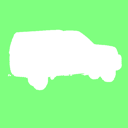

If it doesn't or you get errors, double check the code you have completed above and fix it before moving on.

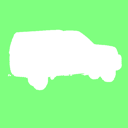

In [17]:
raw_image = Image.open("car.png").convert("RGB").resize((512, 512))

# These are the coordinates of two points on the car
input_points = [[[150, 170], [300, 250]]]

mask = get_processed_inputs(raw_image, input_points)

Image.fromarray(mask).resize((128, 128))

## Inpainting

Now that we have completed the SAM setup, let's move to the inpainting setup.

Let's start by loading our inpainting pipeline. We will use the `diffusers/stable-diffusion-xl-1.0-inpainting-0.1` pretrained model and the `AutoPipelineForInpainting` as we have seen in our `diffusers` demo in Lesson 5.

Complete the following code:

In [20]:
# Load the Inpainting pipeline (remember the diffusers demo in lesson 5)
# YOUR CODE HERE
pipeline = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1", torch_dtype=torch.float16
)

# This will make it more efficient on our hardware
pipeline.enable_model_cpu_offload()

text_encoder_2/config.json: 100%|██████████| 758/758 [00:00<00:00, 4.26MB/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json: 100%|██████████| 737/737 [00:00<00:00, 110kB/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json: 100%|██████████| 472/472 [00:00<00:00, 2.65MB/s]


tokenizer/merges.txt: 100%|██████████| 525k/525k [00:00<00:00, 6.89MB/s]



tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]
tokenizer_2/special_tokens_map.json: 100%|██████████| 460/460 [00:00<00:00, 2.16MB/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]



tokenizer_2/tokenizer_config.json: 100%|██████████| 725/725 [00:00<00:00, 74.1kB/s]

tokenizer/vocab.json: 100%|██████████| 1.06M/1.06M [00:00<00:00, 13.1MB/s]



unet/config.json: 100%|██████████| 1.93k/1.93k [00:00<00:00, 10.3MB/s]
tokenizer_2/merges.txt: 100%|██████████| 525k/525k [00:00<00:00, 6.32

model.safetensors:  79%|███████▉  | 388M/492M [00:02<00:00, 191MB/s]

model.safetensors:  15%|█▍        | 409M/2.78G [00:02<00:12, 193MB/s]


diffusion_pytorch_model.safetensors:   4%|▍         | 388M/10.3G [00:02<00:52, 187MB/s]



model.safetensors:  83%|████████▎ | 409M/492M [00:02<00:00, 193MB/s]

model.safetensors:  15%|█▌        | 430M/2.78G [00:02<00:12, 195MB/s]


diffusion_pytorch_model.safetensors:   4%|▍         | 409M/10.3G [00:02<00:51, 190MB/s]



model.safetensors:  87%|████████▋ | 430M/492M [00:02<00:00, 195MB/s]

model.safetensors:  16%|█▌        | 451M/2.78G [00:02<00:11, 197MB/s]


diffusion_pytorch_model.safetensors:   4%|▍         | 430M/10.3G [00:02<00:50, 194MB/s]



model.safetensors:  92%|█████████▏| 451M/492M [00:02<00:00, 197MB/s]

model.safetensors:  17%|█▋        | 472M/2.78G [00:02<00:11, 198MB/s]


diffusion_pytorch_model.safetensors:   4%|▍         | 451M/10.3G [00:02<00:50, 195MB/s]



model.safetensors:  96%|█████████▌| 472M/492M [00:02<00:00, 197MB/s]

model.safetensors:  55%|█████▌    | 1.54G/2.78G [00:07<00:05, 208MB/s]


diffusion_pytorch_model.safetensors:  14%|█▍        | 1.44G/10.3G [00:07<00:43, 203MB/s]

model.safetensors:  56%|█████▌    | 1.56G/2.78G [00:07<00:05, 208MB/s]


diffusion_pytorch_model.safetensors:  14%|█▍        | 1.46G/10.3G [00:07<00:43, 204MB/s]

model.safetensors:  57%|█████▋    | 1.58G/2.78G [00:08<00:05, 206MB/s]


diffusion_pytorch_model.safetensors:  14%|█▍        | 1.48G/10.3G [00:07<00:43, 203MB/s]

model.safetensors:  58%|█████▊    | 1.60G/2.78G [00:08<00:05, 206MB/s]


diffusion_pytorch_model.safetensors:  15%|█▍        | 1.51G/10.3G [00:08<00:42, 207MB/s]

model.safetensors:  58%|█████▊    | 1.63G/2.78G [00:08<00:05, 205MB/s]


diffusion_pytorch_model.safetensors:  15%|█▌        | 1.54G/10.3G [00:08<00:41, 209MB/s]

model.safetensors:  60%|█████▉    | 1.66G/2.78G [00:08<00:05, 208MB/s]


diffusion_pytorch_model.safetensors:  15%|█▌        | 1.57G/10.3G [00:08<00:41, 211MB/s]

model.safetensors:  61

model.safetensors:  91%|█████████ | 2.52G/2.78G [00:14<00:01, 145MB/s]


diffusion_pytorch_model.safetensors:  25%|██▍       | 2.56G/10.3G [00:14<00:47, 162MB/s]

model.safetensors:  92%|█████████▏| 2.55G/2.78G [00:14<00:01, 163MB/s]


diffusion_pytorch_model.safetensors:  25%|██▌       | 2.58G/10.3G [00:14<00:44, 171MB/s]

model.safetensors:  92%|█████████▏| 2.57G/2.78G [00:14<00:01, 172MB/s]


diffusion_pytorch_model.safetensors:  25%|██▌       | 2.60G/10.3G [00:14<00:43, 178MB/s]

model.safetensors:  94%|█████████▎| 2.60G/2.78G [00:14<00:00, 185MB/s]


diffusion_pytorch_model.safetensors:  26%|██▌       | 2.62G/10.3G [00:14<00:48, 158MB/s]

model.safetensors:  94%|█████████▍| 2.62G/2.78G [00:15<00:00, 160MB/s]


diffusion_pytorch_model.safetensors:  26%|██▌       | 2.64G/10.3G [00:14<00:45, 167MB/s]

model.safetensors:  95%|█████████▌| 2.64G/2.78G [00:15<00:00, 161MB/s]


diffusion_pytorch_model.safetensors:  26%|██▌       | 2.66G/10.3G [00:15<00:46, 165MB/s]

model.safetensors:  96

diffusion_pytorch_model.safetensors:  40%|███▉      | 4.08G/10.3G [00:23<00:38, 160MB/s]


diffusion_pytorch_model.safetensors:  40%|███▉      | 4.10G/10.3G [00:24<00:39, 155MB/s]


diffusion_pytorch_model.safetensors:  40%|████      | 4.12G/10.3G [00:24<00:37, 164MB/s]


diffusion_pytorch_model.safetensors:  40%|████      | 4.14G/10.3G [00:24<00:34, 175MB/s]


diffusion_pytorch_model.safetensors:  41%|████      | 4.16G/10.3G [00:24<00:41, 148MB/s]


diffusion_pytorch_model.safetensors:  41%|████      | 4.18G/10.3G [00:24<00:40, 151MB/s]


diffusion_pytorch_model.safetensors:  41%|████      | 4.20G/10.3G [00:24<00:36, 164MB/s]


diffusion_pytorch_model.safetensors:  41%|████      | 4.23G/10.3G [00:24<00:37, 160MB/s]


diffusion_pytorch_model.safetensors:  41%|████▏     | 4.25G/10.3G [00:25<00:37, 160MB/s]


diffusion_pytorch_model.safetensors:  42%|████▏     | 4.27G/10.3G [00:25<00:35, 171MB/s]


diffusion_pytorch_model.safetensors:  42%|████▏     | 4.30G/10.3G [00:25<00:33, 178MB/s]



diffusion_pytorch_model.safetensors:  57%|█████▋    | 5.86G/10.3G [00:35<00:26, 165MB/s]


diffusion_pytorch_model.safetensors:  57%|█████▋    | 5.88G/10.3G [00:35<00:26, 165MB/s]


diffusion_pytorch_model.safetensors:  57%|█████▋    | 5.90G/10.3G [00:35<00:30, 145MB/s]


diffusion_pytorch_model.safetensors:  58%|█████▊    | 5.92G/10.3G [00:35<00:28, 150MB/s]


diffusion_pytorch_model.safetensors:  58%|█████▊    | 5.95G/10.3G [00:35<00:27, 156MB/s]


diffusion_pytorch_model.safetensors:  58%|█████▊    | 5.97G/10.3G [00:35<00:25, 168MB/s]


diffusion_pytorch_model.safetensors:  58%|█████▊    | 5.99G/10.3G [00:35<00:26, 163MB/s]


diffusion_pytorch_model.safetensors:  59%|█████▊    | 6.01G/10.3G [00:36<00:24, 173MB/s]


diffusion_pytorch_model.safetensors:  59%|█████▊    | 6.03G/10.3G [00:36<00:24, 170MB/s]


diffusion_pytorch_model.safetensors:  59%|█████▉    | 6.05G/10.3G [00:36<00:24, 170MB/s]


diffusion_pytorch_model.safetensors:  59%|█████▉    | 6.07G/10.3G [00:36<00:23, 180MB/s]



diffusion_pytorch_model.safetensors:  76%|███████▌  | 7.78G/10.3G [00:48<00:12, 199MB/s]


diffusion_pytorch_model.safetensors:  76%|███████▌  | 7.80G/10.3G [00:48<00:12, 201MB/s]


diffusion_pytorch_model.safetensors:  76%|███████▋  | 7.83G/10.3G [00:48<00:11, 207MB/s]


diffusion_pytorch_model.safetensors:  76%|███████▋  | 7.85G/10.3G [00:48<00:11, 202MB/s]


diffusion_pytorch_model.safetensors:  77%|███████▋  | 7.89G/10.3G [00:48<00:11, 206MB/s]


diffusion_pytorch_model.safetensors:  77%|███████▋  | 7.92G/10.3G [00:48<00:11, 207MB/s]


diffusion_pytorch_model.safetensors:  77%|███████▋  | 7.95G/10.3G [00:48<00:11, 209MB/s]


diffusion_pytorch_model.safetensors:  78%|███████▊  | 7.98G/10.3G [00:48<00:10, 209MB/s]


diffusion_pytorch_model.safetensors:  78%|███████▊  | 8.01G/10.3G [00:49<00:10, 212MB/s]


diffusion_pytorch_model.safetensors:  78%|███████▊  | 8.04G/10.3G [00:49<00:10, 208MB/s]


diffusion_pytorch_model.safetensors:  79%|███████▊  | 8.07G/10.3G [00:49<00:10, 209MB/s]



diffusion_pytorch_model.safetensors:  97%|█████████▋| 9.97G/10.3G [00:58<00:01, 189MB/s]


diffusion_pytorch_model.safetensors:  97%|█████████▋| 9.99G/10.3G [00:58<00:01, 194MB/s]


diffusion_pytorch_model.safetensors:  98%|█████████▊| 10.0G/10.3G [00:59<00:01, 201MB/s]


diffusion_pytorch_model.safetensors:  98%|█████████▊| 10.0G/10.3G [00:59<00:01, 193MB/s]


diffusion_pytorch_model.safetensors:  98%|█████████▊| 10.1G/10.3G [00:59<00:01, 191MB/s]


diffusion_pytorch_model.safetensors:  98%|█████████▊| 10.1G/10.3G [00:59<00:00, 197MB/s]


diffusion_pytorch_model.safetensors:  99%|█████████▊| 10.1G/10.3G [00:59<00:00, 199MB/s]


diffusion_pytorch_model.safetensors:  99%|█████████▊| 10.1G/10.3G [00:59<00:00, 201MB/s]


diffusion_pytorch_model.safetensors:  99%|█████████▉| 10.2G/10.3G [00:59<00:00, 200MB/s]


diffusion_pytorch_model.safetensors:  99%|█████████▉| 10.2G/10.3G [00:59<00:00, 206MB/s]


diffusion_pytorch_model.safetensors: 100%|█████████▉| 10.2G/10.3G [01:00<00:00, 207MB/s]



Now complete the following function that gets in input:
1. The raw image
2. The mask generated by SAM (a numpy array)
3. The text prompt for the infill
4. An optional negative prompt
5. An optional seed for repeatibility
6. The Classifier-Free Guidance Scale (CFGS). If you don't remember what this is, refer to the Text Conditioning explanation in Lesson 5

In [23]:
def inpaint(raw_image, input_mask, prompt, negative_prompt=None, seed=74294536, cfgs=7):
    
    mask_image = Image.fromarray(input_mask)
    
    rand_gen = torch.manual_seed(seed)
    
    # Use the pipeline we have created in the previous cell
    # YOUR CODE HERE
    image = pipeline(
        prompt=prompt, 
        negative_prompt=negative_prompt, 
        image=raw_image, 
        mask_image=mask_image, 
        generator=rand_gen, 
        guidance_scale=cfgs
    ).images[0]
    
    return image

Let's test our inpainting on the mask we have obtained earlier with SAM:

In [24]:
# prompt = "a car stuck in traffic in New York on a rainy day"
# prompt = "a car driving on the beach in broad daylight"
prompt = "a car driving on the Mars. Studio lights, 1970s"
negative_prompt = "artifacts, low quality, distortion"

image = inpaint(raw_image, mask, prompt, negative_prompt)

100%|██████████| 49/49 [00:47<00:00,  1.03it/s]


Let's have a look at what we have produced:

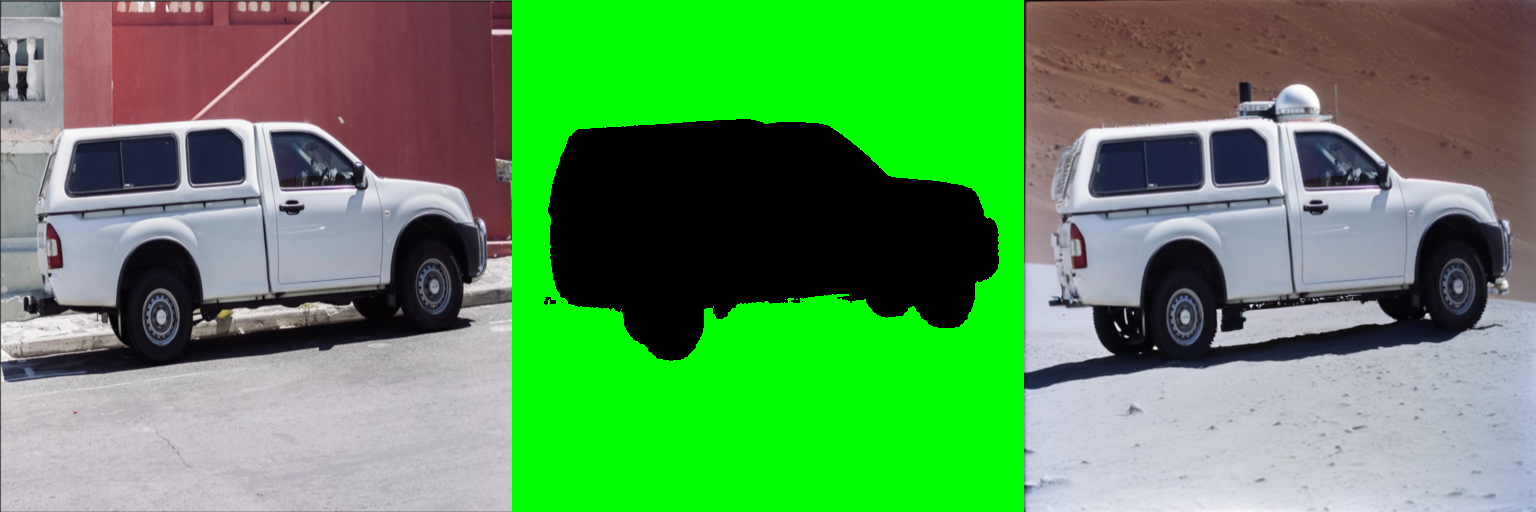

In [26]:
fig = make_image_grid([raw_image, Image.fromarray(mask), image.resize((512, 512))], rows=1, cols=3)
fig

## Interactive app

To make things a bit more fun, we have prepared an interactive app for you that uses the code you have completed and allow you to upload an image, run SAM, and generate the new background through a text prompt.

Simply execute the following cell. The output will contain a preview of the app: **DO NOT USE IT**. Instead, you will also see a link similar to this:



In [27]:
import app

my_app = app.generate_app(get_processed_inputs, inpaint)

ModuleNotFoundError: No module named 'gradio'

In [13]:
my_app.close()

Closing server running on port: 7860
